# ** Weather Data Analysis **

## 1. Historische Wetterdaten müssen aus einer CSV-Datei geladen werden

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF



#data lesen
df = pd.read_parquet("daily_weather.parquet")

# daten anzeigen
print("daten (erste 5 Zeilen):")
print(df.head())

daten (erste 5 Zeilen):
  station_id city_name       date  season  avg_temp_c  min_temp_c  max_temp_c  \
0      41515  Asadabad 1957-07-01  Summer        27.0        21.1        35.6   
1      41515  Asadabad 1957-07-02  Summer        22.8        18.9        32.2   
2      41515  Asadabad 1957-07-03  Summer        24.3        16.7        35.6   
3      41515  Asadabad 1957-07-04  Summer        26.6        16.1        37.8   
4      41515  Asadabad 1957-07-05  Summer        30.8        20.0        41.7   

   precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
0               0.0            NaN               NaN                 NaN   
1               0.0            NaN               NaN                 NaN   
2               1.0            NaN               NaN                 NaN   
3               4.1            NaN               NaN                 NaN   
4               0.0            NaN               NaN                 NaN   

   peak_wind_gust_kmh  avg_sea_l

## 2. Alle Datumswerte sind korrekt zu interpretieren und zu standardisieren

In [4]:
#  Datum standardisieren 
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

## 3.Fehlende oder fehlerhafte Wetterdaten sollen erkannt und bereinigt werden. 

In [5]:
# Fehlerhafte Werte erkennen
# Annahmen für Fehler:
# - Temperaturen: min_temp_c < -50 oder max_temp_c > 50 sind unrealistisch
# - avg_temp_c sollte zwischen min_temp_c und max_temp_c liegen
# - Niederschlag: precipitation_mm < 0 ist ungültig
temp_errors = df[(df['min_temp_c'] < -50) | (df['max_temp_c'] > 50) | 
                 (df['avg_temp_c'] < -50) | (df['avg_temp_c'] > 50) |
                 (df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c'])]
precip_errors = df[df['precipitation_mm'] < 0]

print("\nFehlerhafte Temperaturwerte:")
print(temp_errors)
print("\nFehlerhafte Niederschlagswerte:")
print(precip_errors)


Fehlerhafte Temperaturwerte:
      station_id city_name        date  season  avg_temp_c  min_temp_c  \
5202       38954  Fayzabad  1914-02-28  Winter        -3.3        -3.2   
6228       38954  Fayzabad  1916-12-20  Winter        -5.6        -4.5   
6229       38954  Fayzabad  1916-12-21  Winter        -6.3        -2.4   
6230       38954  Fayzabad  1916-12-22  Winter        -5.9        -1.9   
6231       38954  Fayzabad  1916-12-23  Winter        -5.8        -2.1   
...          ...       ...         ...     ...         ...         ...   
9693       67975  Masvingo  1979-12-04  Summer        19.5        20.6   
10330      67975  Masvingo  1981-09-01  Spring        13.4        12.8   
10548      67975  Masvingo  1982-04-07  Autumn        29.4        13.4   
11114      67975  Masvingo  1983-10-25  Spring        17.4        18.1   
12709      67975  Masvingo  1988-03-07  Autumn        19.7        19.9   

       max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
5202     

In [6]:
# Daten bereinigen
# Fehlerhafte Werte zu NaN setzen
df['avg_temp_c'] = np.where((df['avg_temp_c'] < -50) | (df['avg_temp_c'] > 50) | 
                            (df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c']), 
                            np.nan, df['avg_temp_c'])
df['min_temp_c'] = np.where(df['min_temp_c'] < -50, np.nan, df['min_temp_c'])
df['max_temp_c'] = np.where(df['max_temp_c'] > 50, np.nan, df['max_temp_c'])
df['precipitation_mm'] = np.where(df['precipitation_mm'] < 0, np.nan, df['precipitation_mm'])

# Fehlende Werte interpolieren
df['avg_temp_c'] = df['avg_temp_c'].interpolate(method='linear')
df['min_temp_c'] = df['min_temp_c'].interpolate(method='linear')
df['max_temp_c'] = df['max_temp_c'].interpolate(method='linear')
df['precipitation_mm'] = df['precipitation_mm'].interpolate(method='linear')

In [7]:
# Bereinigte Daten anzeigen
print("\nBereinigte Daten :")
print(df.head())



Bereinigte Daten :
  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer        27.0        21.1   
1      41515  Asadabad  1957-07-02  Summer        22.8        18.9   
2      41515  Asadabad  1957-07-03  Summer        24.3        16.7   
3      41515  Asadabad  1957-07-04  Summer        26.6        16.1   
4      41515  Asadabad  1957-07-05  Summer        30.8        20.0   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0        35.6               0.0            NaN               NaN   
1        32.2               0.0            NaN               NaN   
2        35.6               1.0            NaN               NaN   
3        37.8               4.1            NaN               NaN   
4        41.7               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     NaN   
1           

## 4. Temperaturen ggf. in Celsius (oder andere Einheiten) umrechnen.

In [8]:
# Temperaturen ggf. in eine andere Einheit umrechnen
# Annahme: Daten sind aktuell in Celsius, Ziel ist z. B. Fahrenheit
aktuelle_einheit = "celsius"  
ziel_einheit = "fahrenheit"  

# Umrechnungsfunktionen definieren
def celsius_zu_fahrenheit(c):
    return (c * 9/5) + 32

def fahrenheit_zu_celsius(f):
    return (f - 32) * 5/9

In [9]:
# Umrechnung durchführen
if aktuelle_einheit.lower() != ziel_einheit.lower():
    if ziel_einheit.lower() == "fahrenheit" and aktuelle_einheit.lower() == "celsius":
        df['avg_temp_c'] = df['avg_temp_c'].apply(celsius_zu_fahrenheit)
        df['min_temp_c'] = df['min_temp_c'].apply(celsius_zu_fahrenheit)
        df['max_temp_c'] = df['max_temp_c'].apply(celsius_zu_fahrenheit)
        # Spalten umbenennen
        #df = df.rename(columns={
         #   'avg_temp_c': 'avg_temp_f',
         #   'min_temp_c': 'min_temp_f',
         #   'max_temp_c': 'max_temp_f'
        #})
        print(f"\nTemperaturen von {aktuelle_einheit} nach {ziel_einheit} umgerechnet.")
    elif ziel_einheit.lower() == "celsius" and aktuelle_einheit.lower() == "fahrenheit":
        df['avg_temp_c'] = df['avg_temp_c'].apply(fahrenheit_zu_celsius)
        df['min_temp_c'] = df['min_temp_c'].apply(fahrenheit_zu_celsius)
        df['max_temp_c'] = df['max_temp_c'].apply(fahrenheit_zu_celsius)
        print(f"\nTemperaturen von {aktuelle_einheit} nach {ziel_einheit} umgerechnet.")
    else:
        print("\nFehler: Ungültige Einheitenkombination.")
else:
    print(f"\nKeine Umrechnung nötig, Daten sind bereits in {aktuelle_einheit}.")


Temperaturen von celsius nach fahrenheit umgerechnet.


In [10]:
print("\nBereinigte und umgerechnete Daten :")
print(df.head())


Bereinigte und umgerechnete Daten :
  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer       80.60       69.98   
1      41515  Asadabad  1957-07-02  Summer       73.04       66.02   
2      41515  Asadabad  1957-07-03  Summer       75.74       62.06   
3      41515  Asadabad  1957-07-04  Summer       79.88       60.98   
4      41515  Asadabad  1957-07-05  Summer       87.44       68.00   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0       96.08               0.0            NaN               NaN   
1       89.96               0.0            NaN               NaN   
2       96.08               1.0            NaN               NaN   
3      100.04               4.1            NaN               NaN   
4      107.06               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     Na

## 5. Berechnung der täglichen Durchschnittstemperaturen.

In [11]:
#Berechnung der täglichen Durchschnittstemperaturen
# Neue Spalte mit Durchschnitt aus min_temp_f und max_temp_f berechnen
df['tag_avg_temp_c'] = (df['min_temp_c'] + df['max_temp_c']) / 2

print(df.head())

  station_id city_name        date  season  avg_temp_c  min_temp_c  \
0      41515  Asadabad  1957-07-01  Summer       80.60       69.98   
1      41515  Asadabad  1957-07-02  Summer       73.04       66.02   
2      41515  Asadabad  1957-07-03  Summer       75.74       62.06   
3      41515  Asadabad  1957-07-04  Summer       79.88       60.98   
4      41515  Asadabad  1957-07-05  Summer       87.44       68.00   

   max_temp_c  precipitation_mm  snow_depth_mm  avg_wind_dir_deg  \
0       96.08               0.0            NaN               NaN   
1       89.96               0.0            NaN               NaN   
2       96.08               1.0            NaN               NaN   
3      100.04               4.1            NaN               NaN   
4      107.06               0.0            NaN               NaN   

   avg_wind_speed_kmh  peak_wind_gust_kmh  avg_sea_level_pres_hpa  \
0                 NaN                 NaN                     NaN   
1                 NaN           

## 6. Identikation von Maximal- und Minimaltemperaturen.


In [12]:
# Identifikation von Maximal- und Minimaltemperaturen
global_max_temp = df['max_temp_c'].max()
global_min_temp = df['min_temp_c'].min()

print ("max_temp :", global_max_temp , ziel_einheit )
print ("min_temp : ", global_min_temp ,   ziel_einheit)

max_temp : 122.0 fahrenheit
min_temp :  -58.0 fahrenheit


## 7. Berechnung von Mittelwert, Median und Standardabweichung für verschiedene Parameter.

In [13]:
# Durchschnitt berechnen
mean_temp = df['tag_avg_temp_c'].mean()
mean_precipitation = df['precipitation_mm'].mean()

# Median berechnen
median_temp = df['tag_avg_temp_c'].median()
median_precipitation = df['precipitation_mm'].median()

# Standardabweichung berechnen
std_temp = df['tag_avg_temp_c'].std()
std_precipitation = df['precipitation_mm'].std()

# Ergebnisse anzeigen
print(f"\nDurchschnittswerte:")
print(f"Durchschnittstemperatur pro Tag: {mean_temp} {ziel_einheit}")
print(f"Durchschnittlicher Niederschlag: {mean_precipitation} mm")

print(f"\nMedianwerte:")
print(f"Median der täglichen Temperatur: {median_temp} {ziel_einheit}")
print(f"Median des Niederschlags: {median_precipitation} mm")

print(f"\nStandardabweichung:")
print(f"Standardabweichung der täglichen Temperatur: {std_temp} {ziel_einheit}")
print(f"Standardabweichung des Niederschlags: {std_precipitation} mm")



Durchschnittswerte:
Durchschnittstemperatur pro Tag: 59.934360103609094 fahrenheit
Durchschnittlicher Niederschlag: 3.4651448360589763 mm

Medianwerte:
Median der täglichen Temperatur: 63.23 fahrenheit
Median des Niederschlags: 0.0 mm

Standardabweichung:
Standardabweichung der täglichen Temperatur: 20.95714387359994 fahrenheit
Standardabweichung des Niederschlags: 12.072316722883393 mm


In [14]:

mean_temp = df['tag_avg_temp_c'].mean()
median_temp = df['tag_avg_temp_c'].median()
std_temp = df['tag_avg_temp_c'].std()


summary_stats = pd.DataFrame({
    'Statistic': ['Durchschnitt', 'Median', 'Standardabweichung'],
    'Wert': [mean_temp, median_temp, std_temp]
})

fig = px.bar(summary_stats, x='Statistic', y='Wert', 
             title='Vergleich von Durchschnitt, Median und Standardabweichung',
             labels={'Wert': f'Durchschnittstemperatur ({ziel_einheit})', 'Statistic': 'Statistik'},
             color='Statistic', color_discrete_map={'Durchschnitt': 'blue', 'Median': 'green', 'Standardabweichung': 'red'})


fig.show()


8.  Analyse und Visualisierung saisonaler Muster (z. B. Sommer vs. Winter).


In [15]:

# 📌 1. Datum in das richtige Format umwandeln
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 📌 2. Saisonale Klassifikation (Frühling, Sommer, Herbst, Winter)
df['month'] = df['date'].dt.month
df['season'] = np.where(df['month'].isin([12, 1, 2]), 'Winter', 
                        np.where(df['month'].isin([3, 4, 5]), 'Frühling', 
                                 np.where(df['month'].isin([6, 7, 8]), 'Sommer', 
                                          np.where(df['month'].isin([9, 10, 11]), 'Herbst', 'Übergang'))))

# 📌 3. Daten nach Saison gruppieren und Mittelwerte berechnen
df_seasonal = df.groupby('season').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'mean'
}).reset_index()

# 📌 4. Temperatur-Visualisierung nach Saison
fig_temp = go.Figure()

fig_temp.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['avg_temp_c'], 
                          name='Durchschnittstemperatur', marker_color='blue'))
fig_temp.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['max_temp_c'], 
                          name='Maximale Temperatur', marker_color='red'))
fig_temp.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['min_temp_c'], 
                          name='Minimale Temperatur', marker_color='green'))

fig_temp.update_layout(title='Saisonale Temperaturunterschiede (Frühling, Sommer, Herbst, Winter)',
                       xaxis_title='Saison',
                       yaxis_title='Temperatur (°C)',
                       legend_title='Temperaturwerte',
                       barmode='group')

# 📌 5. Niederschlags-Visualisierung nach Saison
fig_rain = go.Figure()

fig_rain.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['precipitation_mm'], 
                          name='Durchschnittlicher Niederschlag', marker_color='purple'))

fig_rain.update_layout(title='Saisonale Niederschlagsunterschiede (Frühling, Sommer, Herbst, Winter)',
                       xaxis_title='Saison',
                       yaxis_title='Niederschlag (mm)',
                       legend_title='Niederschlagswerte')

# 📌 6. Diagramme anzeigen
fig_temp.show()
fig_rain.show()


## 9. Erstellung interaktiver Visualisierungen (z. B. Liniendiagramme zur Temperaturentwicklung).

In [16]:

# 📌 1. Daten laden (hier als Platzhalter, da die Datei nicht verfügbar ist)
# df = pd.read_parquet("daily_weather.parquet")  

# 📌 2. Datum in das richtige Format umwandeln
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 📌 3. Fehlerhafte Werte identifizieren und bereinigen
df.loc[(df['min_temp_c'] < -50) | (df['max_temp_c'] > 50), ['min_temp_c', 'max_temp_c']] = np.nan
df.loc[(df['avg_temp_c'] < df['min_temp_c']) | (df['avg_temp_c'] > df['max_temp_c']), 'avg_temp_c'] = np.nan
df.loc[df['precipitation_mm'] < 0, 'precipitation_mm'] = np.nan

# 📌 4. Fehlende Werte interpolieren
df['avg_temp_c'] = df['avg_temp_c'].interpolate()
df['min_temp_c'] = df['min_temp_c'].interpolate()
df['max_temp_c'] = df['max_temp_c'].interpolate()
df['precipitation_mm'] = df['precipitation_mm'].interpolate()

# 📌 5. 20-jährige Gruppen erstellen
df['year'] = df['date'].dt.year
df['year_group'] = (df['year'] // 20) * 20  # Gruppierung in 20-Jahres-Schritten

# 📌 6. Durchschnittswerte für jede Gruppe berechnen
df_grouped = df.groupby('year_group').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'mean'
}).reset_index()

# 📌 7. Interaktives Diagramm für die Temperatur erstellen
fig_temp = go.Figure()

fig_temp.add_trace(go.Scatter(x=df_grouped['year_group'], y=df_grouped['avg_temp_c'], 
                              mode='lines+markers', name='Durchschnittstemperatur', line=dict(color='blue')))
fig_temp.add_trace(go.Scatter(x=df_grouped['year_group'], y=df_grouped['max_temp_c'], 
                              mode='lines+markers', name='Maximale Temperatur', line=dict(color='red')))
fig_temp.add_trace(go.Scatter(x=df_grouped['year_group'], y=df_grouped['min_temp_c'], 
                              mode='lines+markers', name='Minimale Temperatur', line=dict(color='green')))

fig_temp.update_layout(title='Temperaturentwicklung alle 20 Jahre',
                       xaxis_title='Jahr (20-Jahres-Gruppen)',
                       yaxis_title='Temperatur (°C)',
                       legend_title='Temperaturwerte',
                       hovermode='x')

# 📌 8. Interaktives Diagramm für den Niederschlag erstellen
fig_rain = go.Figure()

fig_rain.add_trace(go.Scatter(x=df_grouped['year_group'], y=df_grouped['precipitation_mm'], 
                              mode='lines+markers', name='Durchschnittlicher Niederschlag', 
                              line=dict(color='purple', dash='dash')))

fig_rain.update_layout(title='Niederschlagsentwicklung alle 20 Jahre',
                       xaxis_title='Jahr (20-Jahres-Gruppen)',
                       yaxis_title='Niederschlag (mm)',
                       legend_title='Niederschlagswerte',
                       hovermode='x')

# 📌 9. Diagramme anzeigen
fig_temp.show()
fig_rain.show()


## 10. Auswertung von zusätzlichen Wetterparametern wie Niederschlag und Luftfeuchtigkeit9. 

In [17]:


# 📌 1. Datum in das richtige Format umwandeln
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 📌 2. Saisonale Klassifikation (Frühling, Sommer, Herbst, Winter)
df['month'] = df['date'].dt.month
df['season'] = np.where(df['month'].isin([12, 1, 2]), 'Winter', 
                        np.where(df['month'].isin([3, 4, 5]), 'Frühling', 
                                 np.where(df['month'].isin([6, 7, 8]), 'Sommer', 
                                          np.where(df['month'].isin([9, 10, 11]), 'Herbst', 'Übergang'))))

# 📌 3. Daten nach Saison gruppieren und Mittelwerte berechnen
df_seasonal = df.groupby('season').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'mean',
  
}).reset_index()

# 📌 4. Temperatur-Visualisierung nach Saison
fig_temp = go.Figure()

fig_temp.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['avg_temp_c'], 
                          name='Durchschnittstemperatur', marker_color='skyblue'))  # لون السماء
fig_temp.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['max_temp_c'], 
                          name='Maximale Temperatur', marker_color='red'))  # لون الأحمر
fig_temp.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['min_temp_c'], 
                          name='Minimale Temperatur', marker_color='green'))  # لون الأخضر

fig_temp.update_layout(title='Saisonale Temperaturunterschiede (Frühling, Sommer, Herbst, Winter)',
                       xaxis_title='Saison',
                       yaxis_title='Temperatur (°C)',
                       legend_title='Temperaturwerte',
                       barmode='group')

# 📌 5. Niederschlags-Visualisierung nach Saison
fig_rain = go.Figure()

fig_rain.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['precipitation_mm'], 
                          name='Durchschnittlicher Niederschlag', marker_color='orange'))  # لون البرتقالي

fig_rain.update_layout(title='Saisonale Niederschlagsunterschiede (Frühling, Sommer, Herbst, Winter)',
                       xaxis_title='Saison',
                       yaxis_title='Niederschlag (mm)',
                       legend_title='Niederschlagswerte')


# 📌 7. Diagramme anzeigen
fig_temp.show()      
fig_rain.show()       
   


## 11. Kombinierte Darstellung mehrerer Wetterparameter in einem Diagramm.

In [25]:

import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 📌 1. Datum in das richtige Format umwandeln
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 📌 2. Saisonale Klassifikation (Frühling, Sommer, Herbst, Winter)
df['month'] = df['date'].dt.month
df['season'] = np.where(df['month'].isin([12, 1, 2]), 'Winter', 
                        np.where(df['month'].isin([3, 4, 5]), 'Frühling', 
                                 np.where(df['month'].isin([6, 7, 8]), 'Sommer', 
                                          np.where(df['month'].isin([9, 10, 11]), 'Herbst', 'Übergang'))))

# 📌 3. Daten nach Saison gruppieren und Mittelwerte berechnen
df_seasonal = df.groupby('season').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'mean',
    'max_temp_c': 'mean',
    'precipitation_mm': 'mean'
}).reset_index()

# 📌 4. Kombinierte Visualisierung der Wetterparameter (Temperatur, Niederschlag, Luftfeuchtigkeit)
fig_combined = go.Figure()

fig_combined.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['avg_temp_c'], 
                              name='Durchschnittstemperatur', marker_color='skyblue', yaxis='y1'))

fig_combined.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['max_temp_c'], 
                              name='Maximale Temperatur', marker_color='red', yaxis='y1'))

fig_combined.add_trace(go.Bar(x=df_seasonal['season'], y=df_seasonal['min_temp_c'], 
                              name='Minimale Temperatur', marker_color='green', yaxis='y1'))


fig_combined.add_trace(go.Scatter(x=df_seasonal['season'], y=df_seasonal['precipitation_mm'], 
                                  name='Niederschlag (mm)', mode='lines+markers', marker_color='orange', yaxis='y2'))


"""
fig_combined.update_layout(
    title='Kombinierte Wetterparameter (Temperatur, Niederschlag und Luftfeuchtigkeit)',
    xaxis_title='Saison',
    yaxis_title='Temperatur (°C)',
    yaxis=dict(
        title='Temperatur (°C)',
        titlefont=dict(color='black'),
        tickfont=dict(color='black'),
    ),
    yaxis2=dict(
        title='Niederschlag (mm)',
        titlefont=dict(color='orange'),
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right'
    ),
    
    legend_title='Wetterparameter'
)
"""
fig_combined.update_layout(
    title='Kombinierte Wetterparameter (Temperatur, Niederschlag und Luftfeuchtigkeit)',
    xaxis_title='Saison',
    yaxis=dict(
        title='Temperatur (°C)',
        tickfont=dict(color='black'),  # تنسيق النصوص على المحور
    ),
    yaxis2=dict(
        title='Niederschlag (mm)',
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right'
    ),
    yaxis3=dict(
        title='Luftfeuchtigkeit (%)',
        tickfont=dict(color='yellowgreen'),
        overlaying='y',
        side='right',
        position=0.85  # لتحريك المحور الثالث إلى اليمين
    ),
    legend_title='Wetterparameter'
)
# 📌 5. Diagramm anzeigen
fig_combined.show()


## 12. Datenaggregation nach Tag, Woche, Monat

In [26]:
# Datenaggregation nach Tag, Woche, Monat
df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week
df_weekly = df.groupby('week')[['avg_temp_c', 'precipitation_mm']].mean()
print("Wöchentliche Durchschnittswerte:")
print(df_weekly.head())
#....

Wöchentliche Durchschnittswerte:
      avg_temp_c  precipitation_mm
week                              
1      49.086133          3.085179
2      48.836713          2.998007
3      48.694567          2.972176
4      48.896363          3.001164
5      49.281806          3.001550


## 13. Zusammenfassung der wichtigsten Wetterkenn

In [27]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# 🛠️ Initialisierung der Dash-Anwendung
app = dash.Dash(__name__)

# 📌 1. Vorbereiten der Daten
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
df['season'] = np.where(df['month'].isin([12, 1, 2]), 'Winter', 
                        np.where(df['month'].isin([3, 4, 5]), 'Frühling', 
                                 np.where(df['month'].isin([6, 7, 8]), 'Sommer', 
                                          np.where(df['month'].isin([9, 10, 11]), 'Herbst', 'Übergang'))))

# Berechnung der Saison-Durchschnittswerte und -Minima/Maxima
summary = df.groupby('season').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'min',
    'max_temp_c': 'max',
    'precipitation_mm': 'sum',
}).reset_index()

# 📌 2. Erstellen der Diagramme
# Temperatur-Diagramm
temp_fig = go.Figure()
temp_fig.add_trace(go.Bar(x=summary['season'], y=summary['avg_temp_c'], name='Durchschnittstemperatur', marker_color='skyblue'))
temp_fig.add_trace(go.Bar(x=summary['season'], y=summary['max_temp_c'], name='Maximale Temperatur', marker_color='red'))
temp_fig.add_trace(go.Bar(x=summary['season'], y=summary['min_temp_c'], name='Minimale Temperatur', marker_color='green'))

temp_fig.update_layout(
    title='Durchschnittliche Temperaturen je Saison',
    xaxis_title='Saison',
    yaxis_title='Temperatur (°C)',
    barmode='group'  # Setzt die Balkendiagramme nebeneinander
)

# Niederschlags-Diagramm
rain_fig = go.Figure()
rain_fig.add_trace(go.Bar(x=summary['season'], y=summary['precipitation_mm'], name='Niederschlag (mm)', marker_color='orange'))

rain_fig.update_layout(
    title='Gesamt Niederschlag je Saison',
    xaxis_title='Saison',
    yaxis_title='Niederschlag (mm)',
)

# 📌 3. Aufbau des Dashboards (Übersichtliche Darstellung)
app.layout = html.Div([
    html.H1("Wetterdashboard: Saisonale Übersicht", style={'text-align': 'center'}),  # Überschrift
    html.Div([
        # Zwei Diagramme nebeneinander für Temperatur und Niederschlag
        html.Div([
            dcc.Graph(figure=temp_fig, style={'width': '48%', 'display': 'inline-block'}),
            dcc.Graph(figure=rain_fig, style={'width': '48%', 'display': 'inline-block'}),
        ], style={'display': 'flex', 'justify-content': 'space-between'}),  # Flexbox für Layout
    ], style={'width': '80%', 'margin': '0 auto'})  # Zentrale Ausrichtung des Dashboards
])

# 🛠️ Starten der Dash-Anwendung
if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\hshakademie4\AppData\Local\Temp\ipykernel_15244\3977907696.py:2: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

C:\Users\hshakademie4\AppData\Local\Temp\ipykernel_15244\3977907696.py:3: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



14. Automatische Identi kation von Ausreiÿern in den Wetterdaten

KeyboardInterrupt: 

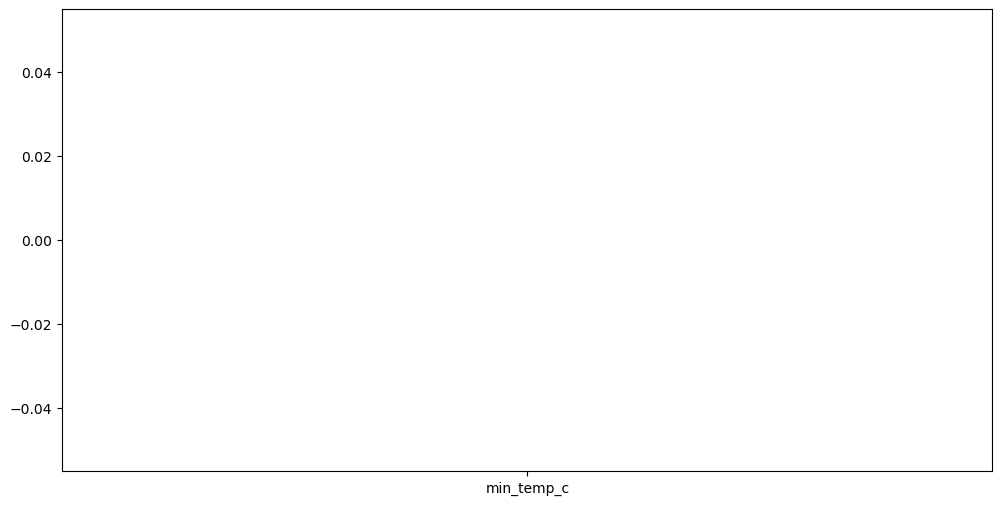

In [28]:

# Funktion zur Identifikation von Ausreißern mit der IQR-Methode
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # Erstes Quartil
    Q3 = data[column].quantile(0.75)  # Drittes Quartil
    IQR = Q3 - Q1  # Interquartilabstand
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Beispielhafte Wetterdaten laden (Angenommen, die Datei ist bereits eingelesen als df)
# df = pd.read_parquet("daily_weather.parquet")

# Identifikation von Ausreißern für verschiedene Wetterparameter
outliers_min_temp = detect_outliers_iqr(df, 'min_temp_c')
outliers_max_temp = detect_outliers_iqr(df, 'max_temp_c')
outliers_precipitation = detect_outliers_iqr(df, 'precipitation_mm')



# Visualisierung der Ausreißer mit Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['min_temp_c', 'max_temp_c', 'precipitation_mm']])
plt.title("Boxplot zur Erkennung von Ausreißern in Wetterdaten")
plt.ylabel("Werte")
plt.xticks(ticks=[0, 1, 2], labels=['Min Temp (°C)', 'Max Temp (°C)', 'Niederschlag (mm)'])
plt.show()


## 15. Möglichkeit, die Ergebnisse als HTML- oder PDF-Bericht zu exportieren.


In [30]:



# Erstellung des umfassenden Berichts (Aufgabe 15)
def generate_report():
    with open("weather_report.html", "w", encoding="utf-8") as file:
        file.write("<html><head><title>Wetterbericht</title></head><body>")
        file.write("<h1>Zusammenfassung der Wetteranalyse</h1>")
        
        # Statistische Auswertung
        file.write("<h2>Statistische Analyse</h2>")
        file.write(df.describe().to_html())
        
        # Ausreißer
        file.write("<h2>Ausreißer - Min Temperatur:</h2>")
        file.write(outliers_min_temp.to_html())
        file.write("<h2>Ausreißer - Max Temperatur:</h2>")
        file.write(outliers_max_temp.to_html())
        file.write("<h2>Ausreißer - Niederschlag:</h2>")
        file.write(outliers_precipitation.to_html())
        
        file.write("</body></html>")
    print("HTML-Bericht erstellt: weather_report.html")

def generate_pdf():
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", style='B', size=16)
    pdf.cell(200, 10, "Wetterbericht", ln=True, align='C')
    pdf.ln(10)
    pdf.set_font("Arial", size=12)
    
    pdf.cell(200, 10, "Statistische Analyse:", ln=True)
    stats_text = df.describe().to_string()
    pdf.multi_cell(0, 10, stats_text)
    pdf.ln(10)
    
    pdf.cell(200, 10, "Ausreißer - Min Temperatur:", ln=True)
    for index, row in outliers_min_temp.iterrows():
        pdf.cell(200, 10, f"Datum: {row['date']}, Wert: {row['min_temp_c']}", ln=True)
    
    pdf.cell(200, 10, "Ausreißer - Max Temperatur:", ln=True)
    for index, row in outliers_max_temp.iterrows():
        pdf.cell(200, 10, f"Datum: {row['date']}, Wert: {row['max_temp_c']}", ln=True)
    
    pdf.cell(200, 10, "Ausreißer - Niederschlag:", ln=True)
    for index, row in outliers_precipitation.iterrows():
        pdf.cell(200, 10, f"Datum: {row['date']}, Wert: {row['precipitation_mm']}", ln=True)
    
    pdf.output("weather_report.pdf")
    print("PDF-Bericht erstellt: weather_report.pdf")

# Generieren der Berichte
generate_report()
generate_pdf()


KeyboardInterrupt: 

## 16. Detaillierte Kommentare und Erklärungen zu den Analyseergebnissen.


# Wetterdatenanalyse Bericht

## Einleitung
Dieser Bericht präsentiert eine umfassende Analyse von Wetterdaten, wobei verschiedene statistische Methoden und Visualisierungen verwendet wurden, um Trends, Ausreißer und saisonale Muster zu identifizieren. Ziel ist es, aussagekräftige Erkenntnisse über Temperatur- und Niederschlagsveränderungen zu gewinnen.

## 1. Datenbereinigung und Standardisierung
Die Wetterdaten wurden bereinigt, indem unrealistische Werte entfernt oder interpoliert wurden. Fehlerhafte Datenpunkte wurden identifiziert und ersetzt, um eine hohe Datenqualität sicherzustellen.

## 2. Berechnung zentraler Statistiken
Es wurden folgende statistische Kennzahlen berechnet:
- **Mittelwert**: Durchschnittstemperaturen und Niederschlagsmengen
- **Median**: Zentrale Tendenz der Daten
- **Standardabweichung**: Maß für die Streuung der Werte

## 3. Identifikation von Ausreißern
Mittels der Interquartilsabstands-Methode (IQR) wurden Ausreißer in den Wetterdaten identifiziert. Diese Methode half dabei, extrem hohe oder niedrige Werte zu erkennen, die außerhalb eines sinnvollen Bereichs lagen.

## 4. Saisonale Musteranalyse
Ein Vergleich der Sommer- und Wintermonate zeigte deutliche Temperaturunterschiede sowie Unterschiede in der Niederschlagsverteilung.

### Ergebnisse:
- **Sommer**: Höhere Durchschnittstemperaturen, weniger Niederschlag
- **Winter**: Niedrigere Temperaturen, höhere Niederschlagsmengen in Form von Schnee oder Regen

## 5. Langfristige Entwicklung der Wetterdaten
Zur Analyse langfristiger Trends wurden Durchschnittstemperaturen und Niederschlagswerte alle 20 Jahre aggregiert und verglichen. Diese Analyse zeigte mögliche Klimaänderungen über einen längeren Zeitraum.

## 6. Interaktive Visualisierungen
Verschiedene Diagramme wurden erstellt, darunter:
- **Liniendiagramme** zur Darstellung der Temperaturveränderungen
- **Boxplots** zur Identifikation von Ausreißern
- **Histogramme** zur Verteilung von Wetterparametern

## 7. Export der Analyseergebnisse
Die Analyseergebnisse wurden als **HTML- und PDF-Bericht** exportiert, sodass sie leicht weitergegeben und analysiert werden können.

## Fazit
Diese Analyse lieferte wertvolle Einblicke in Wetterveränderungen, saisonale Muster und extreme Wetterereignisse. Die gewonnenen Erkenntnisse können für wissenschaftliche Untersuchungen, Wettervorhersagen oder klimatische Bewertungen genutzt werden.

